## Final exercise

The goal of this exercise is to visualize seasonal temperature anomalies in Sodankylä during a 100+ years time period. The data is provided by the NOAA Global Historical Climate Network database and it is offered in Fahrenheit degrees. Results of this exercise include four different plots for every season. These plots include information about temperature anomalies between monhtly average temperature values and seasonally average values during reference time period 1951-1980.

### 1.Reading data
First data is read with Python Pandas mo*dule and prepared for the analysis.

In [83]:
import pandas as pd

# Setting file path for our data file
fp = r"data/2315676.txt"

# NaN values are converted and separator is defined.
data = pd.read_csv(fp, skiprows=[1], delim_whitespace=True, na_values=[-9999])

In [84]:
data.head()

,STATION,STATION_NAME,DATE,TAVG,TMAX,TMIN
0,GHCND:FI000007501,SODANKYLA-AWS-FI,19080101,NaN,2.0,-37.0
1,GHCND:FI000007501,SODANKYLA-AWS-FI,19080102,NaN,6.0,-26.0
2,GHCND:FI000007501,SODANKYLA-AWS-FI,19080103,NaN,7.0,-27.0
3,GHCND:FI000007501,SODANKYLA-AWS-FI,19080104,NaN,-3.0,-27.0
4,GHCND:FI000007501,SODANKYLA-AWS-FI,19080105,NaN,4.0,-36.0


In [85]:
# There's two columns that are not needed so these can be deleted.
del data["STATION"]
del data["STATION_NAME"]

### 2. Missing values
Now that the is read succesfully, the focus in on missing values. Missing values in average temperature ("TAVG") column are replaced with average of minimun ("TMIN") and maximum daily temperatures. These values are calculated to a new column called "min_max_mean".

In [86]:
# Creating new column
data["min_max_mean"] = (data["TMAX"] + data["TMIN"]) / 2 

# Replacing NaN values in TAVG column with values from min_max_mean column
data.TAVG.fillna(data.min_max_mean, inplace=True)

# Deleting oberscations that still have TMAX NaN values. These observations either had no value in TMIN and/or TMAX columns.
data.dropna(subset=["TMAX"], inplace=True)

### 3. Converting Fahrenheit to Celsius__ 
Next Fahrenheit temperatures are converted to Celsius degrees. To do this, a function is created and used for every observation.

In [87]:
# First original TAVG column name is changed to "TEMP"
data = data.rename(columns={"TAVG": "TEMP_F"})

# New column for Celsius values is created
data["TEMP_C"] = ""

# A function for converting the values is defined
def fahr_to_celsius(fahrenheit_value):
    converted_value = (fahrenheit_value - 32) / 1.8
    return converted_value

# Every value in TEMP_F column is converted with new function and values are stored in TEMP_C column
data["TEMP_C"] = data["TEMP_F"].apply(fahr_to_celsius)

### 4.Calculating seasonal average temperatures for every year
Data is divided to four different seasons based on the observation date. For this purpose, new column for year and month is created. After this average temperature for every season is calculated with a function.


In [88]:
# Date column is converted to string so that string slicing can be used to extract year and month numbers
data["DATE_STR"] = data["DATE"].astype(str)

# New columns for year and month are created and sliced numbers is stored in these columns. Month is needed now and year later on when working with reference time period
data["YEAR"] = data["DATE_STR"].str.slice(start=0, stop=4)
data["MONTH"] = data["DATE_STR"].str.slice(start=4, stop=6)


# Function is created to categorize observations to different seasons based on month
def set_season(row):
    if row["MONTH"] == "12" or row["MONTH"] == "01" or row["MONTH"] == "02":
         return "winter"
    if row["MONTH"] == "03" or row["MONTH"] == "04" or row["MONTH"] == "05":
        return "spring"
    if row["MONTH"] == "06" or row["MONTH"] == "07" or row["MONTH"] == "08":
        return "summer"
    if row["MONTH"] == "09" or row["MONTH"] == "10" or row["MONTH"] == "11":
        return "autumn"

# New season column is filled with return values of set_season function   
data["SEASON"] = data.apply(lambda row: set_season(row), axis=1)

Now that observations are categorized to four different seasons, mean values for every month can be calculated. For this purpose, a new dataframe and new function are created.

In [89]:
# New column for year and season together is created so that grouping is easier
data["YEAR_SEASON"] = data["YEAR"] + data["SEASON"]

# Grouping is done based on year and season and grouped data is stored in variable called grouped
grouped = data.groupby(by="YEAR_SEASON")

# Creating new dataframe for data grouped by season and year
season_data = pd.DataFrame()

# Defining which columns from grouped dataframe is used for mean calculatioions
mean_cols = ["TEMP_C"]

# Iterating over all of the groups
for key, group in grouped:
    # Calculating mean values
    mean_values = group[mean_cols].mean()
    # Adding key into the aggregated values
    mean_values["YEAR_SEASON"] = key
    # Converting mean values series to dataframe with row orientation
    row = mean_values.to_frame().transpose()
    # Adding monthly mean values to season_data dataframe
    season_data = pd.concat([season_data, row], ignore_index=True)

### 5. Calculating seasonal average temperatures for the reference period__
Data is divided to four different seasons and mean temperature for every season during reference period is calculated. Data selection is done so that reference period of 1951-1980 is covered.

In [90]:
# Converting year column to integer numbers so that filtering data is easier
data["YEAR_INT"] = data["YEAR"].astype(int)

# Selecting winter data from original dataframe
winter_temps = data.loc[data["SEASON"] == "winter"]
winter_temps_ref = winter_temps.loc[(data["YEAR_INT"] >= 1951) & (data["YEAR_INT"] <= 1980)]

# Calculating mean temperature for winter months of reference period
ref_mean_winter = winter_temps_ref["TEMP_C"].mean()

Let's repeat same steps for every other season so we get three reference mean temperatures in their own variables.

In [91]:
# Spring
spring_temps =  data.loc[data["SEASON"] == "spring"]
spring_temps_ref = spring_temps.loc[(data["YEAR_INT"] >= 1951) & (data["YEAR_INT"] <= 1980)]
ref_mean_spring =  spring_temps_ref["TEMP_C"].mean()

# Summer
summer_temps =  data.loc[data["SEASON"] == "summer"]
summer_temps_ref = summer_temps.loc[(data["YEAR_INT"] >= 1951) & (data["YEAR_INT"] <= 1980)]
ref_mean_summer =  summer_temps_ref["TEMP_C"].mean()

# Autumn
autumun_temps =  data.loc[data["SEASON"] == "autumn"]
autumn_temps_ref = autumun_temps.loc[(data["YEAR_INT"] >= 1951) & (data["YEAR_INT"] <= 1980)]
ref_mean_autumn =  autumn_temps_ref["TEMP_C"].mean()

Mean temperatures for reference time period seem to be following: 
* winter: -13.6 °C <br> 
* spring: -2.3 °C <br> 
* summer: 12.4 °C <br> 
* autumun: -0.8 °C <br> 
 → These values seem reasonable for Sodankylä weather station since it is located in Northern Finland. Because values seem to make sense the next step is to calculate differences between monthly average values and seasonally average temperatures during reference time period. For this purpose, mean temperature for every season during reference time period has to be filled to season_data dataframe.

In [92]:
# Let's create season column also into the season_data dataframe so it can be used to fill mean reference values
season_data["SEASON"] = season_data["YEAR_SEASON"].str.slice(start=4)

# Reference mean values are filled with a function. This function uses conditional statements to define which season should use which mean temperature
def set_mean_ref_value(row):
    if row["SEASON"] == "winter":
         return ref_mean_winter
    if row["SEASON"] == "spring":
         return ref_mean_spring
    if row["SEASON"] == "summer":
         return ref_mean_summer
    if row["SEASON"] == "autumn":
         return ref_mean_autumn

# New function is applied to dataframe and values are added to ref_mean column
season_data["REF_MEAN"] = season_data.apply(lambda row: set_mean_ref_value(row), axis=1)

### 6. Calculating seasonal temperature anomalies for each year
Now that every month in season_data dataframe has monthly average temperatures and matching seasonally average values from reference time period the differences can be calculated. To find out temperature anomalies, reference values are substracted from monthly values. 

In [93]:
# New column for the anomalies are created and substraction of two values is calculated
season_data["DIFFERENCE"] = season_data["TEMP_C"] - season_data["REF_MEAN"]
season_data

,TEMP_C,YEAR_SEASON,SEASON,REF_MEAN,DIFFERENCE
0,-1.859217,1908autumn,autumn,-0.808692,-1.050525
1,-2.346743,1908spring,spring,-2.325973,-0.02077
2,11.425926,1908summer,summer,12.398578,-0.972652
3,-12.330779,1908winter,winter,-13.557795,1.227016
4,-0.155827,1909autumn,autumn,-0.808692,0.652865
...,...,...,...,...,...
447,-11.062092,2019winter,winter,-13.557795,2.495704
448,7.84127,2020autumn,autumn,-0.808692,8.649962
449,-0.970696,2020spring,spring,-2.325973,1.355277
450,14.438339,2020summer,summer,12.398578,2.039762


Everything in season_data dataframe seems to be fine so we can move on to plotting the results.

### 7. Plotting the data
Because the goal is to visualize seasonal temperature anomalies, we need four different plots. Subplots are used so we can have multiple plot in different panels on the same figure. This way anomalies in different seasons can be easily compared to each other.

In [133]:
# let's create indexing for the season_data dataframe because it was not done earlier and it makes plotting easier
# First year column is created by slicing year_season column from season_data dataframe
season_data["YEAR_STR"] = season_data["YEAR_SEASON"].str.slice(start=0, stop=4)

# Next this column is converted to integer numbers
season_data["YEAR"] = season_data["YEAR_STR"].astype(int)

# And lastly these year numbers are used as indexes for the whole dataframe and can be used as a base for plotting
season_data.set_index("YEAR", inplace=True)

Next step is to divide the season_data dataset to four different seasons so that they can be plotted separately.

In [155]:
# Only winter time observations from season_data dataframe are chosen
winter_all = season_data.loc[(season_data["SEASON"] == "winter")]

# Anomaly column (difference) is saved to it's own variable so working with the data is easier
winter = winter_all["DIFFERENCE"]

# Same steps are repeated for three other seasons
spring_all = season_data.loc[(season_data["SEASON"] == "spring")]
spring = spring_all["DIFFERENCE"]

summer_all = season_data.loc[(season_data["SEASON"] == "summer")]
summer = summer_all["DIFFERENCE"]

autumn_all = season_data.loc[(season_data["SEASON"] == "autumn")]
autumn = autumn_all["DIFFERENCE"]

So that different plots can be easily compared to each other they should have same minimun and maximum limits for the y-axis. Next the minimum and maximum values of all the seasons are calculated for this purpose. 

In [193]:
# First lower limit for the y-axis is calculated by finding out smallest value of all minimum values
min_temp = min(winter.min(), spring.min(), summer.min(), autumn.min())

# Same procedure is done for upper limit of y-axis
max_temp = max(winter.max(), spring.max(), summer.max(), autumn.max())

# Let's also add little bith of extra to both ends so maximum and minimun values can also be seen from the plots
max_temp = max_temp + 1.0
min_temp = min_temp - 1.0

Let's continue with preparation of the subplots.

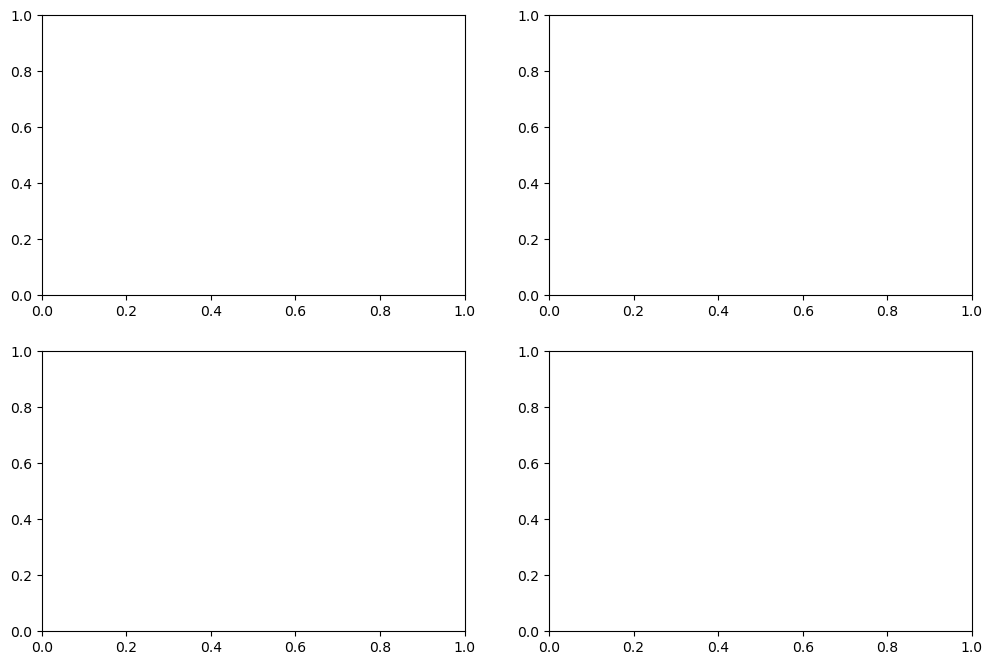

In [226]:
# First let's import new module called matplotlib to make our plot figure
import matplotlib.pyplot as plt

# Figure size and layout are defined
fig, axes = plt. subplots(nrows=2, ncols=2, figsize=(12,8))

# Parsing axes to their own variables
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]

Next let's move on to the actual plotting.

In [ ]:
# First line with for all the plots is defined
width = 2.0

# Choosing the data for plots and defining line color and width
winter.plot(ax=ax1, c="blue", lw=width, ylim=[min_temp, max_temp])
spring.plot(ax=ax2, c="orange", lw=width, ylim=[min_temp, max_temp])
summer.plot(ax=ax3, c="green", lw=width, ylim=[min_temp, max_temp])
autumn.plot(ax=ax4, c="brown", lw=width, ylim=[min_temp, max_temp])

# Setting figure title
fig.suptitle("Seasonal temperature anomalies between observed mean temperatures and reference period (1951-1980) mean temperatures in Sodankylä during 1908-2020")

# Adding axis labes
ax1.set_xlabel("Year")
ax2.set_xlabel("Year")
ax3.set_xlabel("Year")
ax4.set_xlabel("Year")

# Adding labels for every season
ax1.text(pd.to_datetime("20130215"), -25, "Winter")

fig